In [1]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="BTC",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params,verify=False).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data


def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H


def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H


def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)


def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [2]:
coin_sym_list = 'ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':]  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [3]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,ETH,DASH,LTC
time,,,
2014-01-01,NaN,NaN,0.0320
2014-01-02,NaN,NaN,0.0323
2014-01-03,NaN,NaN,0.0304
2014-01-04,NaN,NaN,0.0298
2014-01-05,NaN,NaN,0.0293
,ETH,DASH,LTC
time,,,
2018-09-25,0.03402,0.02952,0.008928
2018-09-26,0.03317,0.02843,0.008857


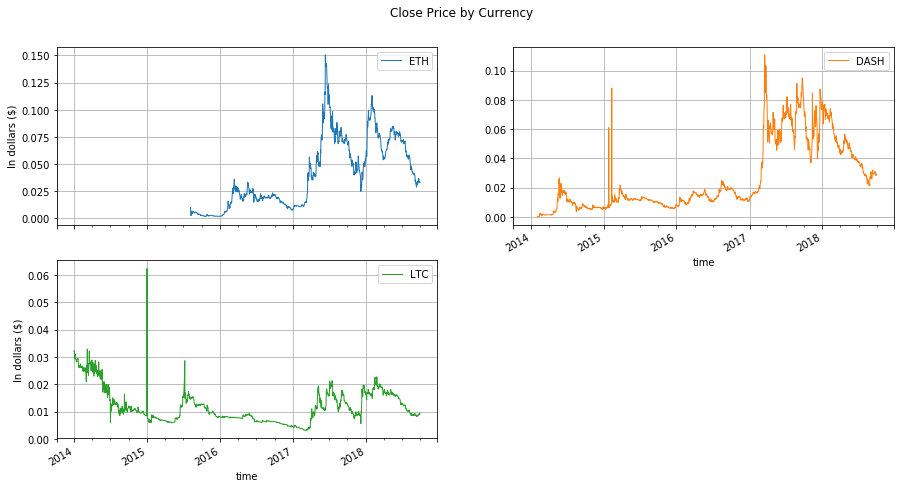

In [4]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [5]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:189: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
ETH,0.449052,0.641815,0.493835
DASH,0.181426,0.576430,0.326581
LTC,0.084756,0.544317,0.354701


In [6]:
# the same methodology as shown in the paper.
roll_days = 250
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [7]:
roll_hurst[::50].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-02-09  0.489483  0.535241  0.422627  0.583539  0.606196  0.635148
2018-03-31  0.481479  0.478074  0.562360  0.609430  0.643110  0.588403
2018-05-20  0.502246  0.506500  0.635853  0.745636  0.689210  0.624268
2018-07-09  0.474136  0.489559  0.647195  0.736455  0.679243  0.550637
2018-08-28  0.558980  0.471726  0.543582  0.733163  0.533941  0.579478

In [8]:
roll_hurst[::50].mean()

DASH  DSOD    0.427188
      RS      0.551859
ETH   DSOD    0.496383
      RS      0.629540
LTC   DSOD    0.372219
      RS      0.542857
dtype: float64

In [9]:
roll_hurst[::50].median()

DASH  DSOD    0.490193
      RS      0.548439
ETH   DSOD    0.490713
      RS      0.629753
LTC   DSOD    0.436040
      RS      0.547993
dtype: float64

In [10]:
roll_hurst[::50].mean(level=0, axis=1);

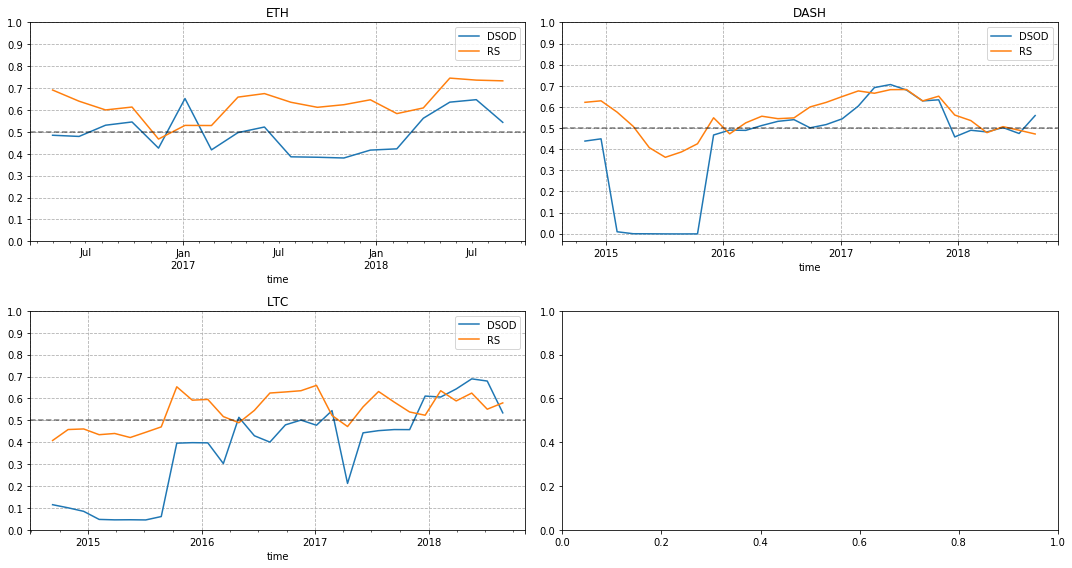

In [11]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [12]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-09-25  0.580655  0.539576  0.524000  0.731848  0.548976  0.557534
2018-09-26  0.576549  0.538694  0.518345  0.731804  0.545672  0.557065
2018-09-27  0.572692  0.537972  0.512841  0.731415  0.542408  0.556427
2018-09-28  0.569402  0.537610  0.507729  0.730667  0.539228  0.555671
2018-09-29  0.565790  0.537074  0.502497  0.730144  0.536180  0.555100

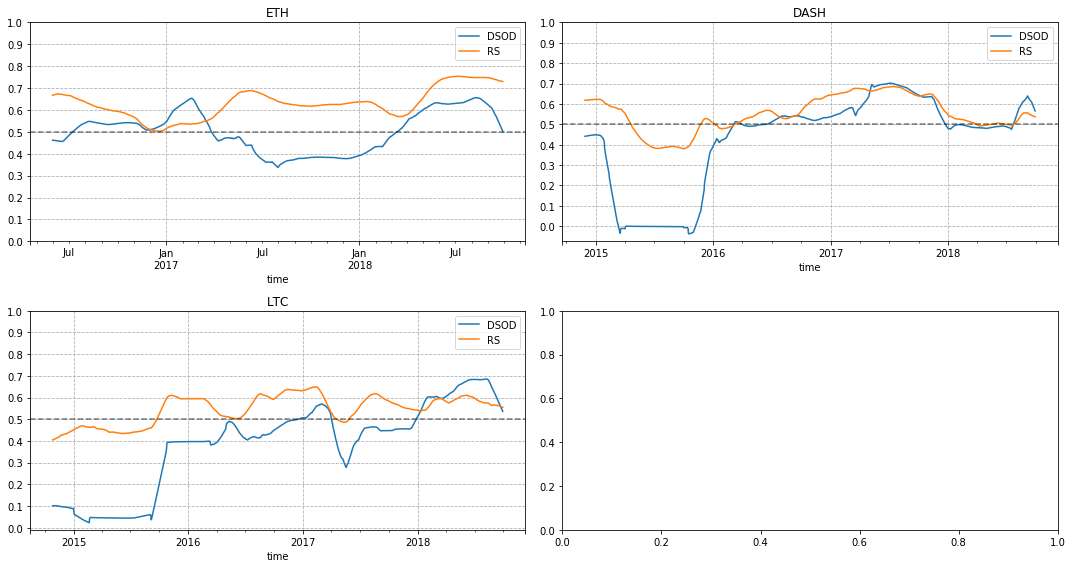

In [13]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [14]:
roll_hurst[::30].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-05-10  0.501135  0.490404  0.641111  0.733031  0.687491  0.617885
2018-06-09  0.487256  0.501834  0.618281  0.751535  0.683922  0.596163
2018-07-09  0.474136  0.489559  0.647195  0.736455  0.679243  0.550637
2018-08-08  0.700198  0.603483  0.663082  0.746005  0.691288  0.584599
2018-09-07  0.542767  0.463907  0.535791  0.705440  0.524600  0.564044

In [15]:
roll_hurst[::30].mean()

DASH  DSOD    0.427081
      RS      0.549472
ETH   DSOD    0.498030
      RS      0.629145
LTC   DSOD    0.384143
      RS      0.545790
dtype: float64

In [16]:
roll_hurst[::30].median()

DASH  DSOD    0.494017
      RS      0.534266
ETH   DSOD    0.492428
      RS      0.629540
LTC   DSOD    0.433938
      RS      0.555720
dtype: float64

In [17]:
roll_hurst[::30].mean(level=0, axis=1);

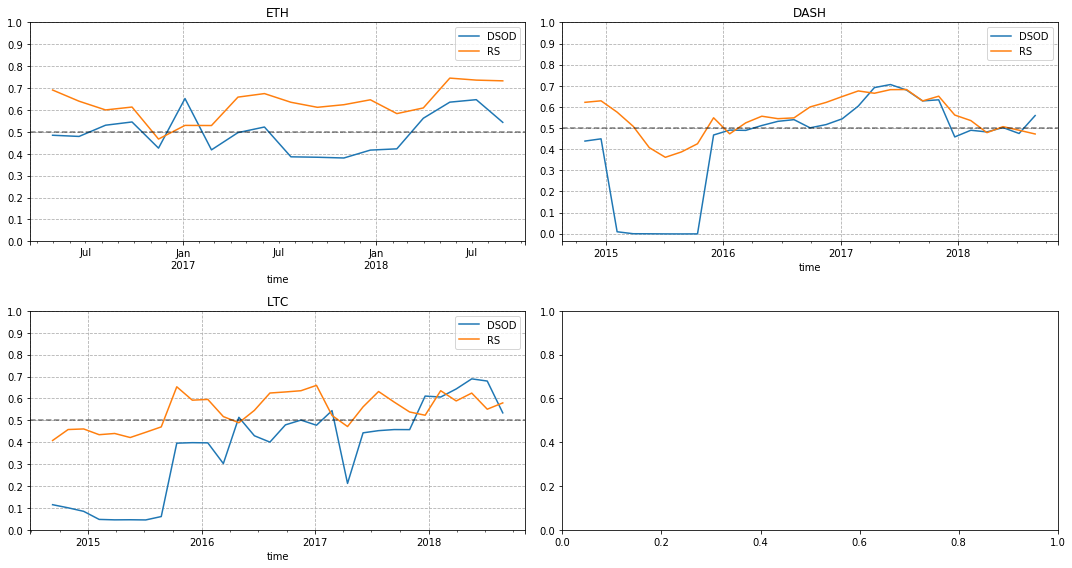

In [18]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [19]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-09-25  0.559813  0.512348  0.475412  0.718298  0.527607  0.561245
2018-09-26  0.558090  0.514066  0.470222  0.718530  0.527045  0.560291
2018-09-27  0.556370  0.517256  0.465031  0.718310  0.526850  0.559399
2018-09-28  0.554519  0.520721  0.460244  0.717905  0.526814  0.558645
2018-09-29  0.552266  0.524698  0.454969  0.717796  0.526825  0.557582

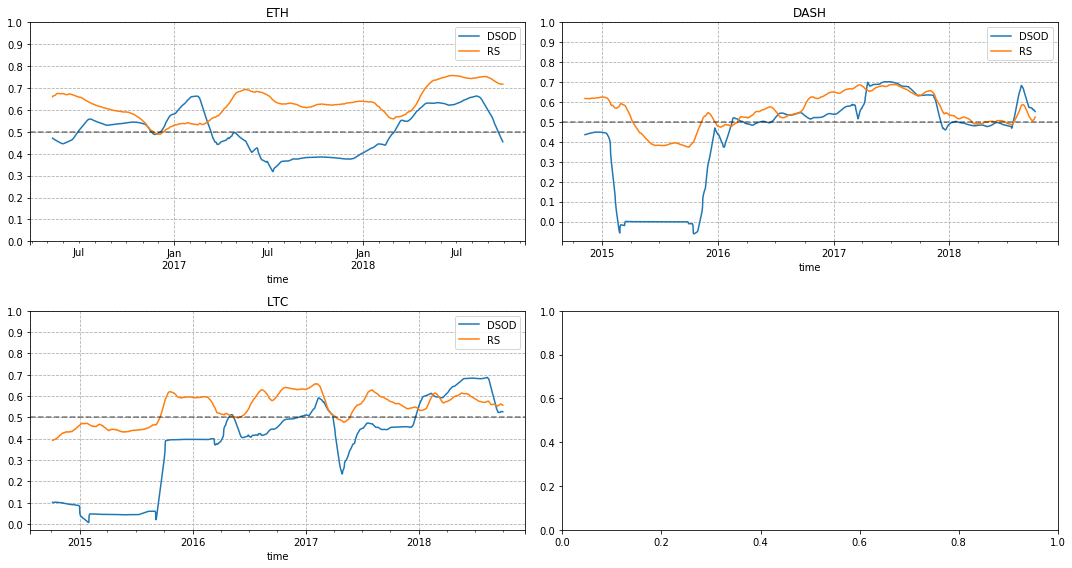

In [20]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [21]:
roll_hurst[::20].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-06-29  0.476063  0.494366  0.650141  0.748470  0.680239  0.573968
2018-07-19  0.690073  0.552635  0.666200  0.743557  0.684698  0.579077
2018-08-08  0.700198  0.603483  0.663082  0.746005  0.691288  0.584599
2018-08-28  0.558980  0.471726  0.543582  0.733163  0.533941  0.579478
2018-09-17  0.589342  0.526626  0.422309  0.711564  0.519950  0.551138

In [22]:
roll_hurst[::20].mean()

DASH  DSOD    0.434805
      RS      0.552752
ETH   DSOD    0.497156
      RS      0.633692
LTC   DSOD    0.385052
      RS      0.543300
dtype: float64

In [23]:
roll_hurst[::20].median()

DASH  DSOD    0.497828
      RS      0.539888
ETH   DSOD    0.496694
      RS      0.632824
LTC   DSOD    0.431638
      RS      0.554352
dtype: float64

In [24]:
roll_hurst[::20].mean(level=0, axis=1);

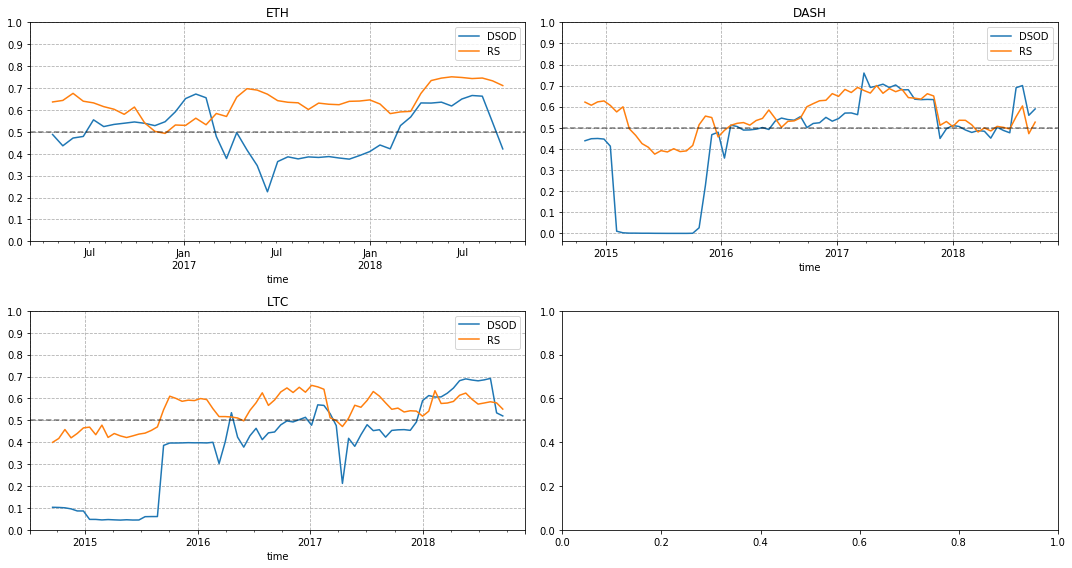

In [25]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [26]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-09-25  0.557354  0.527238  0.438181  0.712933  0.525278  0.554282
2018-09-26  0.556539  0.530378  0.429993  0.714108  0.525658  0.554253
2018-09-27  0.554769  0.535553  0.422596  0.715163  0.525832  0.553687
2018-09-28  0.552414  0.540941  0.415579  0.716154  0.526250  0.552983
2018-09-29  0.552381  0.545181  0.410491  0.717599  0.528963  0.552664

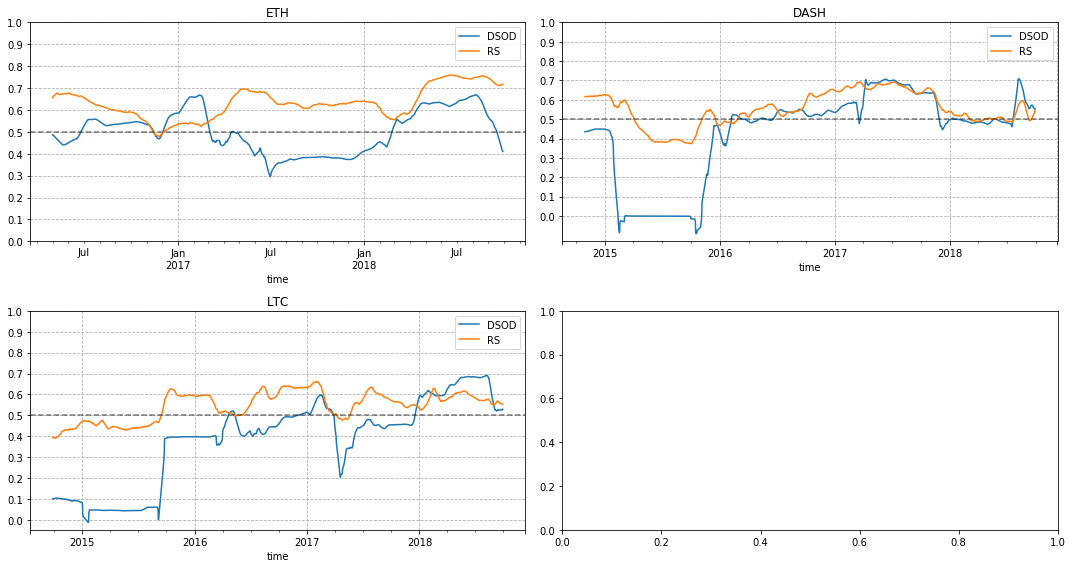

In [27]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [28]:
roll_hurst[::10].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-08-18  0.615246  0.564700  0.577626  0.744685  0.537659  0.527992
2018-08-28  0.558980  0.471726  0.543582  0.733163  0.533941  0.579478
2018-09-07  0.542767  0.463907  0.535791  0.705440  0.524600  0.564044
2018-09-17  0.589342  0.526626  0.422309  0.711564  0.519950  0.551138
2018-09-27  0.507367  0.567413  0.387861  0.726550  0.528073  0.552726

In [29]:
roll_hurst[::10].mean()

DASH  DSOD    0.433127
      RS      0.551168
ETH   DSOD    0.499320
      RS      0.633760
LTC   DSOD    0.382453
      RS      0.543825
dtype: float64

In [30]:
roll_hurst[::10].median()

DASH  DSOD    0.493268
      RS      0.545984
ETH   DSOD    0.517963
      RS      0.632679
LTC   DSOD    0.433938
      RS      0.559547
dtype: float64

In [31]:
roll_hurst[::10].mean(level=0, axis=1);

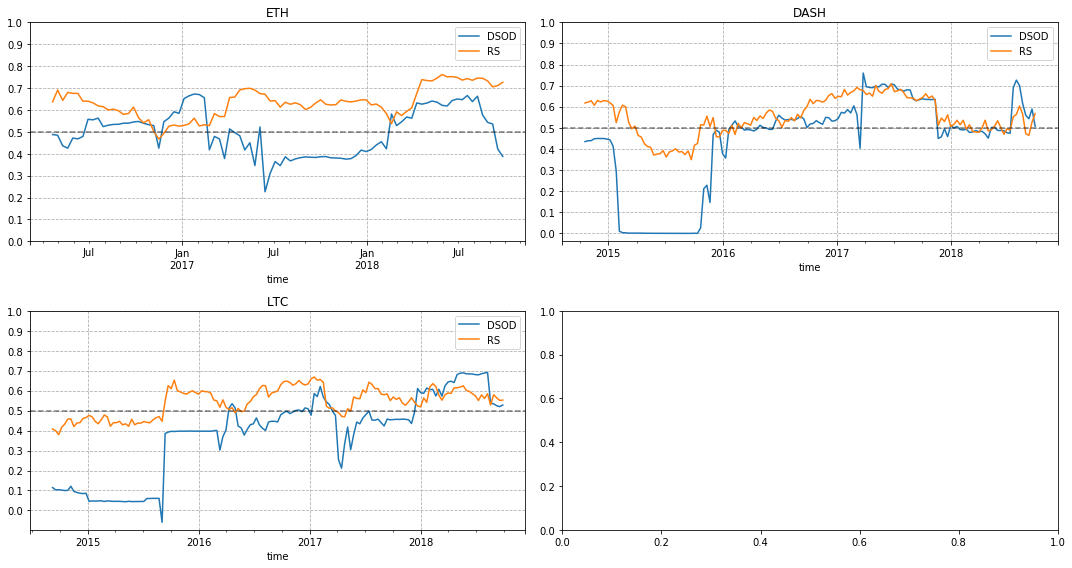

In [32]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [33]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-09-25  0.545025  0.547518  0.398370  0.718440  0.530503  0.552796
2018-09-26  0.533990  0.550344  0.390444  0.720988  0.530686  0.553875
2018-09-27  0.525793  0.554423  0.386999  0.722487  0.531498  0.554033
2018-09-28  0.516422  0.559907  0.389698  0.722874  0.530513  0.553356
2018-09-29  0.510537  0.565135  0.389870  0.724760  0.529981  0.552333

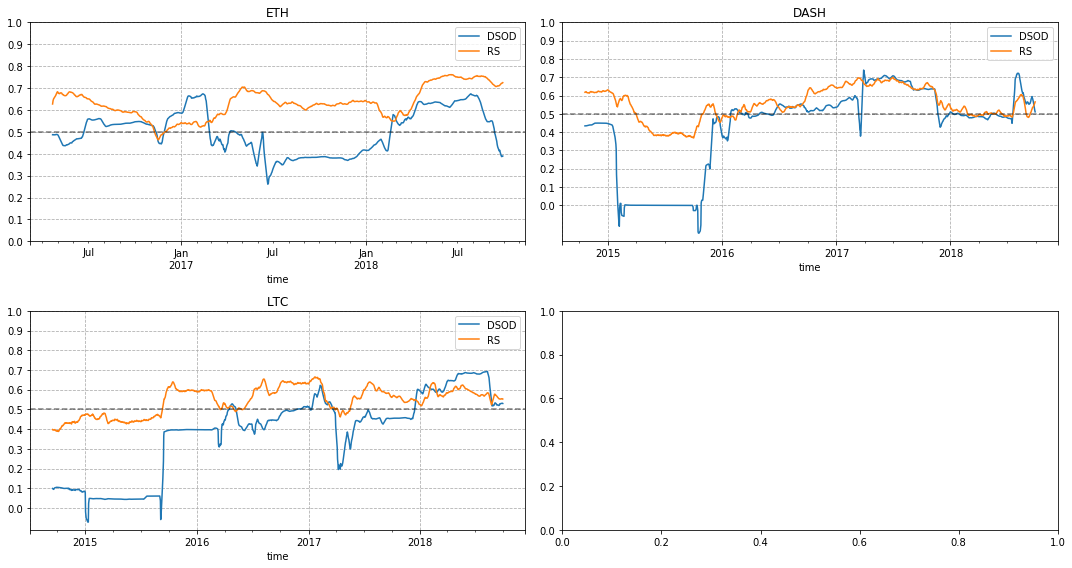

In [34]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
